In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import glob
import os
import scipy.stats as ss
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from __future__ import print_function
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics.cluster import homogeneity_score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import matplotlib.cm as cm
%matplotlib inline

In [ ]:
# Read data 
os.chdir('/content/drive/My Drive/Colab Notebooks/Deepika')
datapath = os.getcwd()+'/Data/'
file = datapath + 'UCI_Credit_Card.csv'
df = pd.read_csv(file, sep = ',', index_col = 0)

# Rename column 'PAY_0' as 'PAY_1'
df.rename(columns = {'PAY_0' : 'PAY_1'}, inplace = True)

# Print dataframe and column datatypes
pd.options.display.max_columns = None
#print(df.head(5))
#print(df.dtypes)
df.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default.payment.next.month'],
      dtype='object')

In [ ]:
# Create lists of continuous and categorical column names
continuous_cols = ['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3',
                   'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
                   'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
categorical_cols = ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_1', 'PAY_2', 'PAY_3',
                    'PAY_4', 'PAY_5', 'PAY_6', 'default.payment.next.month']

# Assign 'object' datatype to categorical columns                    
df[categorical_cols] = df[categorical_cols].astype('category')

# Print unique values for categorical columns
unique_values = {col:list(df[col].unique()) for col in categorical_cols}
for key, value in unique_values.items():
  print(key,value)

SEX [2, 1]
EDUCATION [2, 1, 3, 5, 4, 6, 0]
MARRIAGE [1, 2, 3, 0]
PAY_1 [2, -1, 0, -2, 1, 3, 4, 8, 7, 5, 6]
PAY_2 [2, 0, -1, -2, 3, 5, 7, 4, 1, 6, 8]
PAY_3 [-1, 0, 2, -2, 3, 4, 6, 7, 1, 5, 8]
PAY_4 [-1, 0, -2, 2, 3, 4, 5, 7, 6, 1, 8]
PAY_5 [-2, 0, -1, 2, 3, 5, 4, 7, 8, 6]
PAY_6 [-2, 2, 0, -1, 3, 6, 4, 7, 8, 5]
default.payment.next.month [1, 0]


In [ ]:
# Adjust categorical column values for misrepresented entries
df.loc[~df['EDUCATION'].isin([1, 2, 3, 4]), 'EDUCATION'] = 5
df.loc[~df['MARRIAGE'].isin([1, 2]), 'MARRIAGE'] = 3
df.loc[~df['PAY_1'].isin([-1, 1, 2, 3, 4, 5, 6, 7, 8, 9]), 'PAY_1'] = 0
df.loc[~df['PAY_2'].isin([-1, 1, 2, 3, 4, 5, 6, 7, 8, 9]), 'PAY_2'] = 0
df.loc[~df['PAY_3'].isin([-1, 1, 2, 3, 4, 5, 6, 7, 8, 9]), 'PAY_3'] = 0
df.loc[~df['PAY_4'].isin([-1, 1, 2, 3, 4, 5, 6, 7, 8, 9]), 'PAY_4'] = 0
df.loc[~df['PAY_5'].isin([-1, 1, 2, 3, 4, 5, 6, 7, 8, 9]), 'PAY_5'] = 0
df.loc[~df['PAY_6'].isin([-1, 1, 2, 3, 4, 5, 6, 7, 8, 9]), 'PAY_6'] = 0
categorical_cols = categorical_cols[:-1]

In [ ]:
# Install Java
! apt-get install default-jre
! java -version
# Install h2o library for GLRM
! pip install h2o

Reading package lists... Done
Building dependency tree       
Reading state information... Done
default-jre is already the newest version (2:1.11-68ubuntu1~18.04.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 59 not upgraded.
openjdk version "11.0.7" 2020-04-14
OpenJDK Runtime Environment (build 11.0.7+10-post-Ubuntu-2ubuntu218.04)
OpenJDK 64-Bit Server VM (build 11.0.7+10-post-Ubuntu-2ubuntu218.04, mixed mode, sharing)


In [ ]:
import h2o # For GLRM
from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator
h2o.init()
h2o.remove_all() # Clean slate - just in case the cluster was already running

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,3 hours 39 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.5
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_unknownUser_g2myph
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.170 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [ ]:
# Write updated dataframe into a single CSV file
df.to_csv('Data/CreditCardDataUpdated.csv', columns = df.columns) 

In [ ]:
# Import data as h2o dataframe
dfh2o = h2o.import_file(path = os.path.realpath("Data/CreditCardDataUpdated.csv"))
dfh2o.types

Parse progress: |█████████████████████████████████████████████████████████| 100%


{'AGE': 'int',
 'BILL_AMT1': 'int',
 'BILL_AMT2': 'int',
 'BILL_AMT3': 'int',
 'BILL_AMT4': 'int',
 'BILL_AMT5': 'int',
 'BILL_AMT6': 'int',
 'EDUCATION': 'int',
 'ID': 'int',
 'LIMIT_BAL': 'int',
 'MARRIAGE': 'int',
 'PAY_1': 'int',
 'PAY_2': 'int',
 'PAY_3': 'int',
 'PAY_4': 'int',
 'PAY_5': 'int',
 'PAY_6': 'int',
 'PAY_AMT1': 'int',
 'PAY_AMT2': 'int',
 'PAY_AMT3': 'int',
 'PAY_AMT4': 'int',
 'PAY_AMT5': 'int',
 'PAY_AMT6': 'int',
 'SEX': 'int',
 'default.payment.next.month': 'int'}

In [ ]:
# Reset categorical column data types in h2o dataframe
dfh2o[categorical_cols] = dfh2o[categorical_cols].asfactor()
dfh2o["default.payment.next.month"] = dfh2o["default.payment.next.month"].asfactor()
dfh2o.types

{'AGE': 'int',
 'BILL_AMT1': 'int',
 'BILL_AMT2': 'int',
 'BILL_AMT3': 'int',
 'BILL_AMT4': 'int',
 'BILL_AMT5': 'int',
 'BILL_AMT6': 'int',
 'EDUCATION': 'enum',
 'ID': 'int',
 'LIMIT_BAL': 'int',
 'MARRIAGE': 'enum',
 'PAY_1': 'enum',
 'PAY_2': 'enum',
 'PAY_3': 'enum',
 'PAY_4': 'enum',
 'PAY_5': 'enum',
 'PAY_6': 'enum',
 'PAY_AMT1': 'int',
 'PAY_AMT2': 'int',
 'PAY_AMT3': 'int',
 'PAY_AMT4': 'int',
 'PAY_AMT5': 'int',
 'PAY_AMT6': 'int',
 'SEX': 'enum',
 'default.payment.next.month': 'enum'}

In [ ]:
# Basic GLRM using absolute loss for continuous and categorical loss for
# categorical colimns with no regularization and with stadardized columns
model = H2OGeneralizedLowRankEstimator(k = 8,
                                       loss = "Absolute", multi_loss = "Categorical",
                                       transform = "Standardize",
                                       regularization_x = "None",
                                       regularization_y = "None",
                                       max_iterations = 1000,
                                       min_step_size = 1e-6)
model.train(training_frame = dfh2o)
model.show()

glrm Model Build progress: |██████████████████████████████████████████████| 100%
Model Details
H2OGeneralizedLowRankEstimator :  Generalized Low Rank Modeling
Model Key:  GLRM_model_python_1592572722235_11


Model Summary: 


,,number_of_iterations,final_step_size,final_objective_value
0,,1000.0,0.00003,576221.282211




ModelMetricsGLRM: glrm
** Reported on train data. **

MSE: NaN
RMSE: NaN
Sum of Squared Error (Numeric): 328333.3198105375
Misclassification Error (Categorical): 108159.0

Scoring History: 


,,timestamp,duration,iterations,step_size,objective
0,,2020-06-19 19:17:12,3.401 sec,0.0,0.666667,3.319228e+06
1,,2020-06-19 19:17:13,4.510 sec,1.0,0.444444,3.319228e+06
2,,2020-06-19 19:17:14,5.596 sec,2.0,0.222222,3.319228e+06
3,,2020-06-19 19:17:15,6.684 sec,3.0,0.074074,3.319228e+06
4,,2020-06-19 19:17:16,7.769 sec,4.0,0.018519,3.319228e+06
5,,2020-06-19 19:17:17,8.902 sec,5.0,0.019444,9.518889e+05
6,,2020-06-19 19:17:18,9.997 sec,6.0,0.012963,9.518889e+05
7,,2020-06-19 19:17:19,11.090 sec,7.0,0.008642,9.518889e+05
8,,2020-06-19 19:17:21,12.194 sec,8.0,0.009074,8.169873e+05
9,,2020-06-19 19:17:22,13.291 sec,9.0,0.006049,8.169873e+05



See the whole table with table.as_data_frame()


In [ ]:
# Print importance of each component of GLRM model
model._model_json["output"]["importance"]


Importance of components: 


,,pc1,pc2,pc3
0,Standard deviation,4.956514,0.605843,0.257398
1,Proportion of Variance,0.982668,0.014682,0.002650
2,Cumulative Proportion,0.982668,0.997350,1.000000


In [ ]:
# Split the feature matrix into product of two matrices X and Y
# The matrix X has the same number of rows as the original feature matrix
# but a reduced number of columns representing the original features
# GLRM matrix factors X and Y
X_matrix = h2o.get_frame(model._model_json["output"]["representation_name"])
print(X_matrix)
Y_matrix = model._model_json["output"]["archetypes"]
print(Y_matrix)
print(X_matrix.shape)


Arch1,Arch2,Arch3
0.16977,0.0371941,0.0573564
0.249982,0.0801862,0.139346
0.245592,0.0872509,0.167379
0.203772,0.088097,0.203047
0.229334,0.110908,0.133126
0.230555,0.0851795,0.169653
-0.0664681,0.219869,0.481943
0.254501,0.0797188,0.135809
0.234567,0.0788905,0.14969
0.257105,0.0802795,0.138316




Archetypes: 


,,pay_11,pay_10,pay_11,pay_12,pay_13,pay_14,pay_15,pay_16,pay_17,pay_18,pay_21,pay_20,pay_21,pay_22,pay_23,pay_24,pay_25,pay_26,pay_27,pay_28,pay_31,pay_30,pay_31,pay_32,pay_33,pay_34,pay_35,pay_36,pay_37,pay_38,pay_41,pay_40,pay_41,pay_42,pay_43,pay_44,pay_45,pay_46,pay_47,pay_48,pay_51,pay_50,pay_52,pay_53,pay_54,pay_55,pay_56,pay_57,pay_58,pay_61,pay_60,pay_62,pay_63,pay_64,pay_65,pay_66,pay_67,pay_68,education1,education2,education3,education4,education5,marriage1,marriage2,marriage3,sex1,sex2,defaultpaymentnextmonth0,defaultpaymentnextmonth1,id,limit_bal,age,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6
0,Arch1,-1.242851,1.108920,-4.303666,-4.905946,-6.956604,-7.402189,-7.512478,-7.546839,-7.553639,-7.535252,-1.160108,1.541905,-7.485667,-4.921203,-6.957121,-7.361615,-7.520648,-7.548382,-7.533312,-7.562009,-1.167666,1.518440,-7.557201,-4.910558,-7.021443,-7.417072,-7.527526,-7.525878,-7.494648,-7.557189,-1.185930,1.386619,-7.562648,-4.898548,-7.169942,-7.422253,-7.496588,-7.552905,-7.416308,-7.559722,-1.061557,1.220626,-4.838799,-7.166712,-7.390444,-7.527609,-7.556930,-7.414722,-7.561927,-1.228451,1.400177,-4.868575,-7.131242,-7.454413,-7.537500,-7.520356,-7.444504,-7.560451,-2.559936,-2.730699,-4.023236,-7.165241,-6.976140,-3.784100,3.780202,-6.971930,-2.681179,2.653519,3.182054,-3.133993,-0.589815,-3.300007,-1.535000,-5.970439,-6.179876,-7.239225,-6.310945,-6.294233,-6.398170,-4.289318,-8.282827,-3.629066,-3.023294,-2.734428,-1.996493
1,Arch2,-0.474314,0.975714,-2.799862,-2.776542,-4.758408,-4.960861,-5.015814,-5.031694,-5.033299,-5.024423,-0.381469,0.423907,-4.998735,-2.642639,-4.755701,-4.944969,-5.018946,-5.030423,-5.023584,-5.041103,-0.221487,0.445915,-5.036663,-2.685659,-4.803789,-4.968601,-5.021279,-5.021047,-5.018407,-5.039231,-0.564040,1.236912,-5.039143,-2.794849,-4.861379,-4.974549,-5.009314,-5.037050,-4.990463,-5.040245,-1.443307,2.208184,-2.903517,-4.863830,-4.959926,-5.024922,-5.037343,-4.991128,-5.041237,-0.555787,1.210095,-2.841947,-4.850303,-4.995071,-5.028326,-5.021626,-5.002176,-5.040204,0.375329,-1.810596,-1.903443,-4.848578,-4.666287,-0.560564,0.830788,-4.682203,-0.974147,1.135492,2.299546,-2.586772,1.195497,4.120714,0.977011,3.144351,4.092584,10.715043,4.408919,4.282614,5.211535,16.755282,42.567672,13.876994,9.937138,8.020880,4.507270
2,Arch3,-4.659278,3.897768,-2.357071,-2.208568,-6.865677,-7.183097,-7.297586,-7.329868,-7.331432,-7.311780,-4.819950,4.040849,-7.285411,-2.062222,-6.866088,-7.150269,-7.302203,-7.324710,-7.310008,-7.353822,-4.898544,4.069513,-7.344458,-2.063792,-6.908506,-7.199541,-7.307090,-7.305871,-7.315395,-7.350639,-4.697811,3.857149,-7.349349,-2.215378,-7.002536,-7.218087,-7.285249,-7.346118,-7.270575,-7.352161,-4.433027,3.603796,-2.353408,-7.004135,-7.190295,-7.323521,-7.348385,-7.270028,-7.354409,-4.638756,3.850363,-2.293431,-6.984632,-7.267476,-7.331266,-7.318201,-7.289765,-7.351962,-2.801919,-0.843216,-2.209782,-7.001527,-6.798256,-0.126824,-0.039639,-6.801205,-1.767021,1.723581,1.866040,-1.788647,0.186501,-0.203192,-0.316216,4.257173,4.128689,2.336352,4.323264,4.474160,4.212626,-4.054284,-11.168318,-3.432078,-2.362534,-1.830132,-1.012275



(30000, 3)


In [ ]:
# Data for training and testing
X = np.array(h2o.as_list(X_matrix))
print(X.shape)
y = df['default.payment.next.month'].to_numpy()
print(y.shape)

(30000, 3)
(30000,)


In [ ]:
# Stratified train & test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.25)

In [ ]:
# import model and matrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RepeatedStratifiedKFold, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix,roc_curve, roc_auc_score, precision_score, recall_score, precision_recall_curve
from sklearn.metrics import f1_score

In [ ]:
from sklearn.linear_model import LogisticRegression 
classifier_LR = LogisticRegression(random_state = 0) 
classifier_LR.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
y_pred_LR= classifier_LR.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix 
cm_LR= confusion_matrix(y_test, y_pred_LR) 
print ("Confusion Matrix : \n", cm_LR) 

Confusion Matrix : 
 [[5667  174]
 [1269  390]]


In [ ]:
from sklearn.metrics import accuracy_score 
print ("Accuracy : ", accuracy_score(y_test, y_pred_LR))

from sklearn.metrics import precision_score
precision_LR = precision_score(y_test, y_pred_LR, average='binary')
print('Precision: %.3f' % precision_LR)

from sklearn.metrics import recall_score
recall_LR= recall_score(y_test, y_pred_LR, average='binary')
print('Recall: %.3f' % recall_LR)

from sklearn.metrics import f1_score
score_LR = f1_score(y_test, y_pred_LR, average='binary')
print('F-Measure: %.3f' % score_LR)

specificity_LR = cm_LR[0,0]/(cm_LR[0,0]+cm_LR[0,1])
print('Specificity : ', specificity_LR)

Accuracy :  0.8076
Precision: 0.691
Recall: 0.235
F-Measure: 0.351
Specificity :  0.9702105803800719


Text(0.5, 1.0, 'Precision-Recall curve  0.4664270796857366')

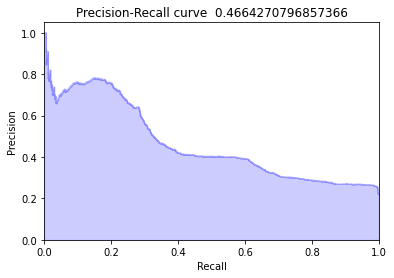

In [ ]:
y_pred_prob_LR = classifier_LR.predict_proba(X_test)[:,1]
from sklearn.metrics import average_precision_score, auc, roc_curve, precision_recall_curve
average_precision = average_precision_score(y_test, y_pred_prob_LR)

#print('Average precision-recall score RF: {}'.format(average_precision))

from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, _ = precision_recall_curve(y_test, y_pred_prob_LR)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title("Precision-Recall curve  {}".format(average_precision))

In [ ]:
from sklearn import tree
classifier_DT = tree.DecisionTreeClassifier()
classifier_DT.fit(X_train,y_train)
y_pred_DT= classifier_DT.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix 
cm_DT = confusion_matrix(y_test, y_pred_DT) 
print ("Confusion Matrix : \n", cm_DT)

Confusion Matrix : 
 [[4952  889]
 [ 851  808]]


In [ ]:
from sklearn.metrics import accuracy_score 
print ("Accuracy : ", accuracy_score(y_test, y_pred_DT))

from sklearn.metrics import precision_score
precision_DT = precision_score(y_test, y_pred_DT, average='binary')
print('Precision: %.3f' % precision_DT)

from sklearn.metrics import recall_score
recall_DT= recall_score(y_test, y_pred_DT, average='binary')
print('Recall: %.3f' % recall_DT)

from sklearn.metrics import f1_score
score_DT = f1_score(y_test, y_pred_DT, average='binary')
print('F-Measure: %.3f' % score_DT)

specificity_DT = cm_DT[0,0]/(cm_DT[0,0]+cm_DT[0,1])
print('Specificity : ', specificity_DT)

Accuracy :  0.8004
Precision: 0.546
Recall: 0.577
F-Measure: 0.561
Specificity :  0.8638931689779148


In [ ]:
from sklearn.svm import SVC
classifier_SVM_rbf=SVC(kernel='rbf',random_state=0)
classifier_SVM_rbf.fit(X_train,y_train)
y_pred_SVM_rbf= classifier_SVM_rbf.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix 
cm_svm_rbf = confusion_matrix(y_test, y_pred_SVM_rbf) 
print ("Confusion Matrix : \n", cm_svm_rbf) 

Confusion Matrix : 
 [[5606  235]
 [1179  480]]


In [ ]:
from sklearn.metrics import accuracy_score 
print ("Accuracy : ", accuracy_score(y_test, y_pred_SVM_rbf))

from sklearn.metrics import precision_score
precision_SVM_rbf = precision_score(y_test, y_pred_SVM_rbf, average='binary')
print('Precision: %.3f' % precision_SVM_rbf)

from sklearn.metrics import recall_score
recall_SVM_rbf= recall_score(y_test, y_pred_SVM_rbf, average='binary')
print('Recall: %.3f' % recall_SVM_rbf)

from sklearn.metrics import f1_score
score_SVM_rbf = f1_score(y_test, y_pred_SVM_rbf, average='binary')
print('F-Measure: %.3f' % score_SVM_rbf)

specificity_SVM_rbf = cm_svm_rbf[0,0]/(cm_svm_rbf[0,0]+cm_svm_rbf[0,1])
print('Specificity : ', specificity_SVM_rbf)

Accuracy :  0.8114666666666667
Precision: 0.671
Recall: 0.289
F-Measure: 0.404
Specificity :  0.9597671631569936
